In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [39]:
df = pd.read_csv('../mbajk_dataset.csv')

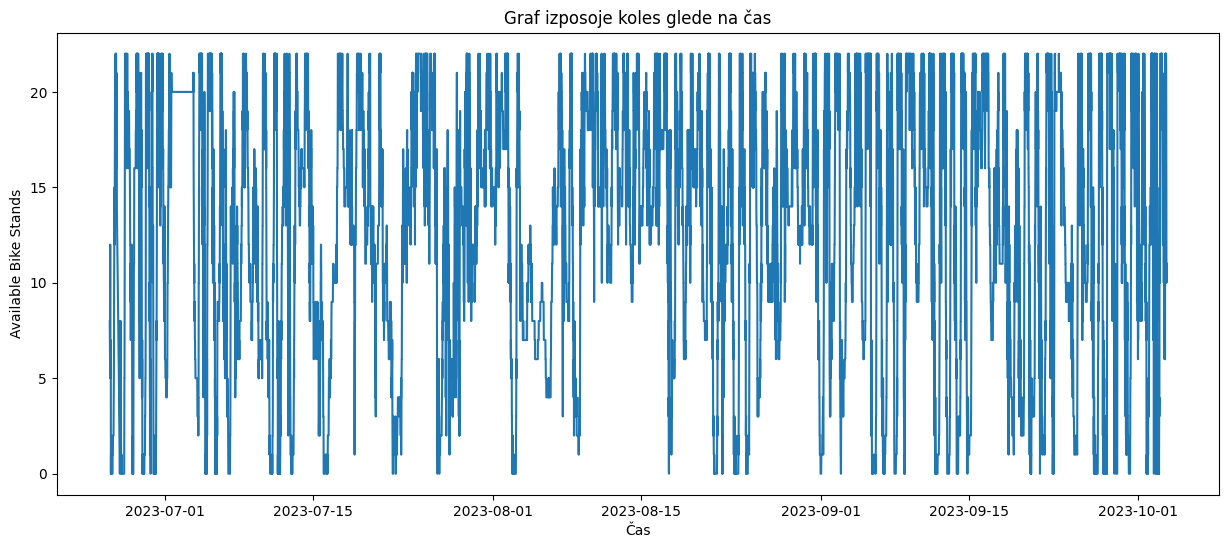

In [40]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['available_bike_stands'])
plt.title('Graf izposoje koles glede na čas')
plt.xlabel('Čas')
plt.ylabel('Available Bike Stands')
plt.show()

In [53]:
# min_values = df.min(axis=0)

# # To get the maximum value of each column
# max_values = df.max(axis=0)

# print("Minimum values of each column:\n", min_values)
# print("\nMaximum values of each column:\n", max_values)

Minimum values of each column:
 Unnamed: 0                     0.0
temperature                    9.3
relative_humidity             27.0
dew_point                      6.3
apparent_temperature           9.0
precipitation_probability      0.0
rain                           0.0
surface_pressure             969.4
bike_stands                   22.0
available_bike_stands          0.0
dtype: float64

Maximum values of each column:
 Unnamed: 0                   18691.0
temperature                     35.8
relative_humidity              100.0
dew_point                       23.1
apparent_temperature            37.0
precipitation_probability      100.0
rain                            23.2
surface_pressure               994.5
bike_stands                     22.0
available_bike_stands           22.0
dtype: float64


In [42]:
# agregacija podatkov
df.set_index('date', inplace=True)

# Resample the data to hourly intervals and calculate the mean
hourly_data = df.resample('H').mean()

# Reset the index if you want the 'date' column back as a regular column
hourly_data.reset_index(inplace=True)

hourly_data

C:\Users\jasas\AppData\Local\Temp\ipykernel_34112\3680548933.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = df.resample('H').mean()


,date,Unnamed: 0,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
0,2023-06-25 19:00:00+00:00,3.000000,24.425000,43.500000,11.275000,23.650000,0.0,0.0,984.450000,22.0,7.250000
1,2023-06-25 20:00:00+00:00,5.500000,22.850000,49.000000,11.500000,22.500000,0.0,0.0,984.450000,22.0,8.500000
2,2023-06-25 21:00:00+00:00,13.500000,20.950000,56.500000,12.000000,21.050000,0.0,0.0,984.550000,22.0,4.333333
3,2023-06-25 22:00:00+00:00,19.000000,19.520000,65.000000,12.500000,19.450000,0.0,0.0,985.000000,22.0,0.500000
4,2023-06-25 23:00:00+00:00,23.000000,18.000000,73.000000,13.100000,18.300000,0.0,0.0,985.250000,22.0,0.166667
...,...,...,...,...,...,...,...,...,...,...,...
2392,2023-10-03 11:00:00+00:00,18642.727273,19.850000,68.727273,13.781818,20.145455,0.0,0.0,987.909091,22.0,12.363636
2393,2023-10-03 12:00:00+00:00,18654.750000,22.300000,66.000000,15.650000,23.600000,0.0,0.0,987.550000,22.0,16.416667
2394,2023-10-03 13:00:00+00:00,18666.000000,24.272727,63.818182,16.972727,26.127273,0.0,0.0,987.136364,22.0,20.181818
2395,2023-10-03 14:00:00+00:00,18677.500000,25.550000,59.000000,16.950000,27.350000,0.0,0.0,986.600000,22.0,19.416667


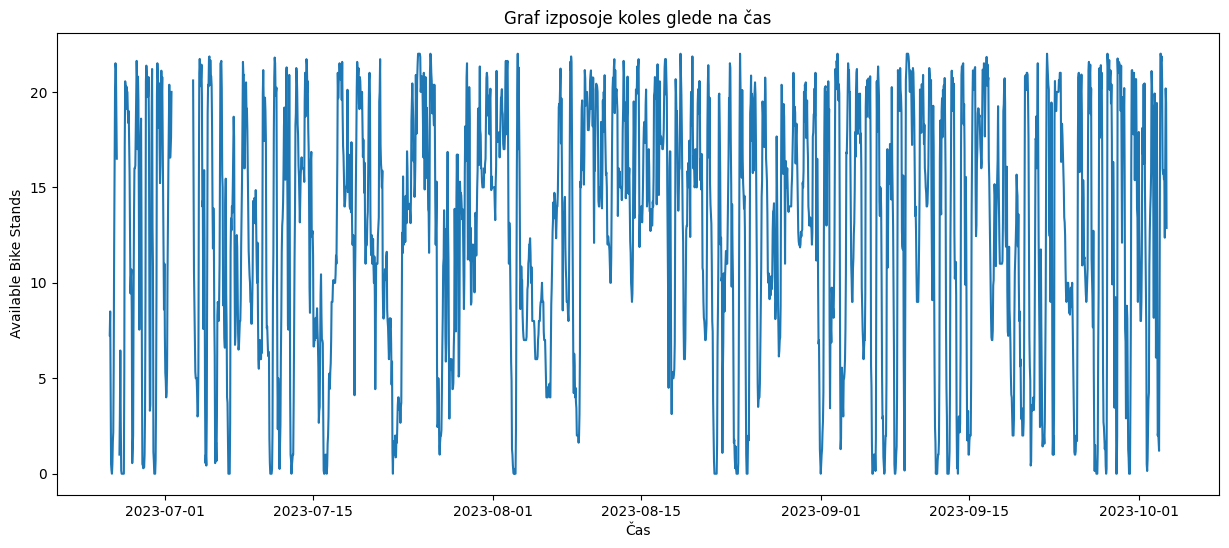

In [43]:
plt.figure(figsize=(15, 6))
plt.plot(hourly_data['date'], hourly_data['available_bike_stands'])
plt.title('Graf izposoje koles glede na čas')
plt.xlabel('Čas')
plt.ylabel('Available Bike Stands')
plt.show()

In [44]:
# filtriramo po available_bike_stands
df_uni = df['available_bike_stands']
uni_array = df_uni.values.reshape(-1, 1)

# razdelitev na učno in testno množico
train_size = len(df_uni) - 1488
train, test = uni_array[0:train_size], uni_array[train_size:]

print('df len', len(df_uni))
print('train len', len(train))
print('test len', len(test))

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

df len 18692
train len 17204
test len 1488


In [45]:
def create_dataset(dataset, window_size=186):
  X, y = [], []
  for i in range(len(dataset) - window_size):
      window = dataset[i:i+window_size, 0]
      target = dataset[i+window_size, 0]
      X.append(window)
      y.append(target)
  return np.array(X), np.array(y)

In [46]:
window_size = 45

X_train, y_train = create_dataset(train_scaled, window_size=window_size)
X_test, y_test = create_dataset(test_scaled, window_size=window_size)

print('Oblika učnih podatkov: X_train: ', X_train.shape, ', y_train:', y_train.shape)
print('Oblika testnih podatkov: X_test: ', X_test.shape, ', y_test:', y_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('Preoblikovani X_train:', X_train.shape)
print('Preoblikovani X_test:', X_test.shape)

Oblika učnih podatkov: X_train:  (17159, 45) , y_train: (17159,)
Oblika testnih podatkov: X_test:  (1443, 45) , y_test: (1443,)
Preoblikovani X_train: (17159, 1, 45)
Preoblikovani X_test: (1443, 1, 45)


In [47]:
def build_gru_model(input_shape):
  model = Sequential()
  model.add(GRU(32, activation='relu', input_shape=input_shape, return_sequences=True))
  model.add(GRU(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [48]:
input_shape = (X_train.shape[1], X_train.shape[2])

gru_model = build_gru_model(input_shape)

gru_history = gru_model.fit(X_train, y_train, epochs=15, validation_split=0.2)

Epoch 1/15
429/429 [==============================] - 3s 2ms/step - loss: 0.1375 - val_loss: 0.0479
Epoch 2/15
429/429 [==============================] - 1s 2ms/step - loss: 0.0369 - val_loss: 0.0409
Epoch 3/15
429/429 [==============================] - 1s 2ms/step - loss: 0.0328 - val_loss: 0.0363
Epoch 4/15
429/429 [==============================] - 1s 2ms/step - loss: 0.0310 - val_loss: 0.0361
Epoch 5/15
429/429 [==============================] - 1s 2ms/step - loss: 0.0302 - val_loss: 0.0360
Epoch 6/15
429/429 [==============================] - 1s 2ms/step - loss: 0.0301 - val_loss: 0.0366
Epoch 7/15
429/429 [==============================] - 1s 2ms/step - loss: 0.0290 - val_loss: 0.0388
Epoch 8/15
429/429 [==============================] - 1s 2ms/step - loss: 0.0290 - val_loss: 0.0360
Epoch 9/15
429/429 [==============================] - 1s 2ms/step - loss: 0.0290 - val_loss: 0.0345
Epoch 10/15
429/429 [==============================] - 1s 2ms/step - loss: 0.0291 - val_loss: 0.0332

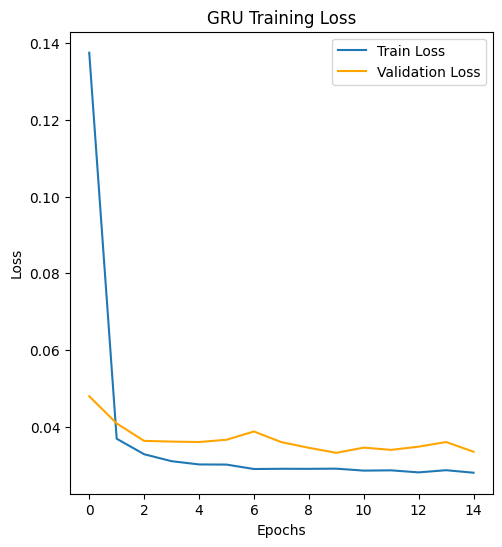

In [49]:
def plot_loss(history, model_name):
  plt.figure(figsize=(12, 6))

  # Plot Training Loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
  plt.title(f'{model_name} Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

# Plotting the loss for each model
plot_loss(gru_history, 'GRU')

In [50]:
print(X_test.shape)

# Napovedovanje za vsak model
gru_predictions = gru_model.predict(X_test)
gru_predictions_inv = scaler.inverse_transform(gru_predictions)

print(gru_predictions.shape)
print(y_test.shape)

(1443, 1, 45)
46/46 [==============================] - 0s 844us/step
(1443, 1)
(1443,)


In [51]:
# Izračun metrik
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

gru_mae = mean_absolute_error(y_test_inv, gru_predictions_inv)
gru_mse = mean_squared_error(y_test_inv, gru_predictions_inv)
gru_evs = explained_variance_score(y_test_inv, gru_predictions_inv)

print("\nGRU Model Metrics:")
print(f"MAE: {gru_mae}, MSE: {gru_mse}, EVS: {gru_evs}")


GRU Model Metrics:
MAE: 1.2386869228908395, MSE: 3.2401783971793408, EVS: 0.9430993233975752


In [52]:
# shrani model in metrike
gru_history_df = pd.DataFrame(gru_history.history)
gru_history_df.to_csv('../reports/train_metrics.txt', sep='\t', index=False)

gru_test_metrics = pd.DataFrame({
    'mae': [gru_mae],
    'mse': [gru_mse],
    'evs': [gru_evs]
})
gru_test_metrics.to_csv('../reports/test_metrics.txt', sep='\t', index=False)

gru_model.save('../models/uni_gru_model.h5')
joblib.dump(scaler, '../models/uni_gru_scaler.pkl')

['../models/uni_gru_scaler.pkl']